In [325]:
import pandas as pd
import pycaret
import json
import shutil
import os
from pycaret.regression import *

# ML Logic

## Data Split 

In [326]:
assets_folder = "data"
pkl_file_path_raw = os.path.join(assets_folder, "df_dtype_converted.pkl")
df_dtype_converted = pd.read_pickle(pkl_file_path_raw)

data = df_dtype_converted.sample(frac=0.95,random_state=123) # 95% data for Model training and testing
evaluation_data = df_dtype_converted.drop(data.index) # 5% data for Final Evaluation


In [327]:
ml_model_report_inputs = {}

In [328]:
# Split Train/Test (70% Train, 30% Test)
train_size = int(0.70 * len(data))  
train_data = data[:train_size]  # First 70% as Train
test_data = data[train_size:]   # Remaining 30% as Test

ml_model_report_inputs['data_split'] = {
    'train_data_size' : len(train_data),
    'test_data_size' : len(test_data),
    'evaluation_data_size' : len(evaluation_data)
}

## User Inputs

In [329]:
assets_folder = "metadata"

json_file_path_user_ip = os.path.join(assets_folder, "user_inputs.json")
with open(json_file_path_user_ip, 'r') as f:
    user_inputs = json.load(f)
    
json_file_path_user_dtype = os.path.join(assets_folder, "user_data_types.json")
with open(json_file_path_user_dtype, 'r') as f:
    user_data_types = json.load(f)

## Preprocessing by Logic

In [330]:
assets_folder = "metadata"
json_file_path_prepocess_ip = os.path.join(assets_folder, "preprocessing_inputs.json") 
with open(json_file_path_prepocess_ip, 'r') as f:
    preprocessing_inputs = json.load(f)

In [331]:
preprocessing_inputs

{'transformation_req': True,
 'normalization_req': True,
 'imput_method': 'mean',
 'outliers_req': True,
 'feature_sele_req': False,
 'multicollinearity_req': False,
 'transform_target_req': True,
 'target_imbalance_req': None}

### User Inputs or Fixed Parameters

In [332]:
# dataFrame Input
# data = df_dtype_converted 

#Target 
target = user_inputs['Target Column']

#remove Features
if user_inputs['Remove Features'] == 'None':
    ignore_features = False
else:
    ignore_features = user_inputs['Remove Features']
    
#Ordinal Features    
ordinal_features = {}
for key, value in user_inputs['Data Types'].items():
    if (value == 'Categorical(Ordinal)') & (len(user_inputs['Ordinal Degree']) != 0):
        ordinal_features  = {key : user_inputs['Ordinal Degree']}
        break
    else:
        ordinal_features = None
    
#bin Numerical features    
if user_inputs['Binning Columns'] == 'None':
    bin_numeric_features = False
else:
    bin_numeric_features = user_inputs['Binning Columns']

#train size    
train_size = int(user_inputs['Training Data Size'].strip('%'))/100  # int(train_size.strip('%'))/100

#Number of K-Flod
fold = int(user_inputs['K-Fold'])

#Numerical Imputation Method
numeric_imputation = preprocessing_inputs['imput_method']


### Combinations of all the Parameters defined by Logic

In [333]:
import itertools

# Assume these booleans come from your GUI
# (If the user requested normalization, transformation, etc.)


# For transformation: if requested, test both on and off
if preprocessing_inputs['transformation_req']:
    # Each tuple: (apply transformation, method)
    transformation_options = [(True, 'yeo-johnson'), (True, 'quantile'), (False, None)]
else:
    transformation_options = [(False, None)]

# For normalization: even if requested, include the off option
if preprocessing_inputs['normalization_req']:
    normalization_options = [(True, 'zscore'), (True, 'minmax'), (True, 'maxabs'), (True, 'robust'), (False, None)]
else:
    normalization_options = [(False, None)]

# For outlier detection: include an option to not remove outliers
if preprocessing_inputs['outliers_req']:
    outlier_options = [(True, 'iforest'), (True, 'ee'), (True, 'lof'), (False, None)]
else:
    outlier_options = [(False, None)]

# For multicollinearity, target transformation, and feature selection, these are simple flags.
if preprocessing_inputs['multicollinearity_req']:
    multicollinearity_options = [True, False]
else:
    multicollinearity_options = [False]

if preprocessing_inputs['transform_target_req']:
    target_transformation_options = [True, False]
else:
    target_transformation_options = [False]

if preprocessing_inputs['feature_sele_req']:
    feature_selection_options = [True, False]
else:
    feature_selection_options = [False]

# Build the grid (each combination is a list of 6 items)
combinations = [list(combo) for combo in itertools.product(
    transformation_options,    # combo[0]: (transformation, method)
    normalization_options,     # combo[1]: (normalize, method)
    outlier_options,           # combo[2]: (remove_outliers, method)
    multicollinearity_options, # combo[3]: flag
    target_transformation_options,  # combo[4]: flag
    feature_selection_options  # combo[5]: flag
)]

# Print grid for verification
for combo in combinations:
    trans_option, norm_option, out_option, multi_option, target_trans_option, feat_select_option = combo
    print("Combination:")
    print(f"  Transformation: {trans_option[0]}, Method: {trans_option[1]}")
    print(f"  Normalization: {norm_option[0]}, Method: {norm_option[1]}")
    print(f"  Outlier Removal: {out_option[0]}, Method: {out_option[1]}")
    print(f"  Multicollinearity: {multi_option}")
    print(f"  Target Transformation: {target_trans_option}")
    print(f"  Feature Selection: {feat_select_option}")
    print("-" * 40)


Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: iforest
  Multicollinearity: False
  Target Transformation: True
  Feature Selection: False
----------------------------------------
Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: iforest
  Multicollinearity: False
  Target Transformation: False
  Feature Selection: False
----------------------------------------
Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: ee
  Multicollinearity: False
  Target Transformation: True
  Feature Selection: False
----------------------------------------
Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: ee
  Multicollinearity: False
  Target Transformation: False
  Feature Selection: False
-----

In [334]:
print(f'Total Preprocessing Combinations Created: {len(combinations)}')

Total Preprocessing Combinations Created: 120


In [335]:
ml_model_report_inputs['total_preprocess_param_comb'] = len(combinations)

### Intial Run to identify top ML models

### Identify top 3 Models to apply preprocessing parameter combinations

In [336]:
from pycaret.regression import *

reg_intital = setup(data = data,
            target= target,
            fold= fold,
            ignore_features= ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation = numeric_imputation,
            ordinal_features= ordinal_features,
            session_id= 123)
compare_models(include=['lr','lasso','ridge','svm','knn','dt','rf','ada','gbr'],sort = 'R2')
reg_initial_compare = pull()
reg_initial_compare.head()
Top_Models_initial = list(reg_initial_compare.index[:3])
print(f'Top 3 Models by {fold} KFlod based in top R2 are {Top_Models_initial}')

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2621.5635,22916632.7917,4741.4442,0.8440,0.4358,0.3043,0.0280
rf,Random Forest Regressor,2736.0402,24861287.5108,4944.5859,0.8308,0.4666,0.3193,0.1680
ada,AdaBoost Regressor,4108.2633,28598931.6791,5335.6514,0.8058,0.6173,0.6863,0.0100
lasso,Lasso Regression,4187.7537,37604850.5363,6102.0297,0.7447,0.5742,0.4195,0.1720
ridge,Ridge Regression,4202.5303,37599336.7545,6101.5581,0.7447,0.6075,0.4221,0.1540
lr,Linear Regression,4187.6391,37605948.8811,6102.0969,0.7446,0.5734,0.4195,0.5060
dt,Decision Tree Regressor,3301.1769,46101596.9880,6781.1992,0.6870,0.5748,0.4134,0.0100
knn,K Neighbors Regressor,8281.9030,138577361.6000,11765.2596,0.0633,0.8634,0.9708,0.1580
svm,Support Vector Regression,8373.4085,166224235.9957,12888.0853,-0.1229,0.9208,0.9728,0.0100


Top 3 Models by 5 KFlod based in top R2 are ['gbr', 'rf', 'ada']


In [337]:
list(reg_initial_compare['R2'])

[0.844, 0.8308, 0.8058, 0.7447, 0.7447, 0.7446, 0.687, 0.0633, -0.1229]

In [338]:
intial_models_comparison = {
    "model" : list(reg_initial_compare['Model']),
    "rmse" : list(reg_initial_compare['RMSE']),
    "r2" : list(reg_initial_compare['R2'])
}

ml_model_report_inputs['intial_models_comparison'] = intial_models_comparison

## Preprocessing Parameters Tuning

In [339]:
model_best_comp = []
model_R2 = []
model_RMSE = []
params = []

for i in range(len(combinations)):
    logic_data = combinations[i]
    trans_option = logic_data[0]  # tuple: (transformation flag, transformation_method)
    norm_option  = logic_data[1]  # tuple: (normalize flag, normalize_method)
    out_option   = logic_data[2]  # tuple: (remove_outliers flag, outliers_method)
    multi_option = logic_data[3]  # flag
    target_trans_option = logic_data[4]  # flag
    feat_select_option = logic_data[5]  # flag

    try:
        reg = setup(
            data=data,
            target=target,
            fold=fold,
            ignore_features=ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation=numeric_imputation,
            ordinal_features=ordinal_features,
            normalize = norm_option[0],             # use grid value
            normalize_method = norm_option[1],
            transformation = trans_option[0],         # use grid value
            transformation_method = trans_option[1],
            remove_outliers = out_option[0],          # use grid value
            outliers_method = out_option[1],
            remove_multicollinearity = multi_option,
            transform_target = target_trans_option,
            feature_selection = feat_select_option,
            session_id = 123
        )
        best_model = compare_models(
            include=Top_Models_initial,
            sort='R2'
        )
        result_int = pull()
        model_best_comp.append(result_int.iloc[0]['Model'])
        model_R2.append(result_int.iloc[0]['R2'])
        model_RMSE.append(result_int.iloc[0]['RMSE'])
        params.append(combinations[i])
    except Exception as e:
        print("Error for combination", combinations[i], ":", e)
        continue

model_comparision_results = {
    'Model': model_best_comp,
    'R2': model_R2,
    'RMSE': model_RMSE,
    'Parameters': params
}

Error for combination [(True, 'yeo-johnson'), (True, 'zscore'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2686.7490,23533861.2395,4810.7520,0.8399,0.4333,0.3049,0.0300
rf,Random Forest Regressor,2777.2317,25316859.4265,5005.3275,0.8278,0.4653,0.3210,0.0420
ada,AdaBoost Regressor,3951.7962,27306765.5519,5213.3776,0.8145,0.5781,0.6213,0.0240


Error for combination [(True, 'yeo-johnson'), (True, 'zscore'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2602.9825,23335313.7161,4781.8599,0.8411,0.4311,0.2955,0.0360
rf,Random Forest Regressor,2717.5306,25063855.2522,4971.8616,0.8294,0.4666,0.3150,0.0480
ada,AdaBoost Regressor,3811.3304,25966634.0741,5073.6542,0.8235,0.5654,0.6003,0.0320


Error for combination [(True, 'yeo-johnson'), (True, 'zscore'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2762.0235,24484052.4569,4908.4655,0.8335,0.4609,0.3396,0.0320
rf,Random Forest Regressor,2805.3879,25269178.2765,4994.9160,0.8280,0.4763,0.3411,0.0360
ada,AdaBoost Regressor,3843.8923,26899369.8471,5167.0787,0.8170,0.5944,0.6399,0.0160


Error for combination [(True, 'yeo-johnson'), (True, 'zscore'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2612.9752,22836389.1902,4732.9684,0.8445,0.4328,0.3003,0.0220
rf,Random Forest Regressor,2734.0481,24761048.7643,4936.9713,0.8315,0.4669,0.3192,0.0340
ada,AdaBoost Regressor,4195.0897,29300178.1019,5402.2407,0.8011,0.6175,0.6922,0.0120


Error for combination [(True, 'yeo-johnson'), (True, 'minmax'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2686.7490,23533861.2395,4810.7520,0.8399,0.4333,0.3049,0.0320
rf,Random Forest Regressor,2777.2317,25316859.4265,5005.3275,0.8278,0.4653,0.3210,0.0420
ada,AdaBoost Regressor,3951.7962,27306765.5519,5213.3776,0.8145,0.5781,0.6213,0.0220


Error for combination [(True, 'yeo-johnson'), (True, 'minmax'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2602.9825,23335313.7161,4781.8599,0.8411,0.4311,0.2955,0.0400
rf,Random Forest Regressor,2717.5306,25063855.2522,4971.8616,0.8294,0.4666,0.3150,0.0520
ada,AdaBoost Regressor,3811.3304,25966634.0741,5073.6542,0.8235,0.5654,0.6003,0.0300


Error for combination [(True, 'yeo-johnson'), (True, 'minmax'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2762.0235,24484052.4569,4908.4655,0.8335,0.4609,0.3396,0.0220
rf,Random Forest Regressor,2805.3879,25269178.2765,4994.9160,0.8280,0.4763,0.3411,0.0360
ada,AdaBoost Regressor,3843.8923,26899369.8471,5167.0787,0.8170,0.5944,0.6399,0.0120


Error for combination [(True, 'yeo-johnson'), (True, 'minmax'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2612.9752,22836389.1902,4732.9684,0.8445,0.4328,0.3003,0.0200
rf,Random Forest Regressor,2734.0481,24761048.7643,4936.9713,0.8315,0.4669,0.3192,0.0320
ada,AdaBoost Regressor,4195.0897,29300178.1019,5402.2407,0.8011,0.6175,0.6922,0.0120


Error for combination [(True, 'yeo-johnson'), (True, 'maxabs'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2686.7490,23533861.2395,4810.7520,0.8399,0.4333,0.3049,0.0320
rf,Random Forest Regressor,2777.2317,25316859.4265,5005.3275,0.8278,0.4653,0.3210,0.0460
ada,AdaBoost Regressor,3951.7962,27306765.5519,5213.3776,0.8145,0.5781,0.6213,0.0240


Error for combination [(True, 'yeo-johnson'), (True, 'maxabs'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2602.9825,23335313.7161,4781.8599,0.8411,0.4311,0.2955,0.0380
rf,Random Forest Regressor,2717.5306,25063855.2522,4971.8616,0.8294,0.4666,0.3150,0.0540
ada,AdaBoost Regressor,3811.3304,25966634.0741,5073.6542,0.8235,0.5654,0.6003,0.0300


Error for combination [(True, 'yeo-johnson'), (True, 'maxabs'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2762.0235,24484052.4569,4908.4655,0.8335,0.4609,0.3396,0.0220
rf,Random Forest Regressor,2805.3879,25269178.2765,4994.9160,0.8280,0.4763,0.3411,0.0320
ada,AdaBoost Regressor,3843.8923,26899369.8471,5167.0787,0.8170,0.5944,0.6399,0.0100


Error for combination [(True, 'yeo-johnson'), (True, 'maxabs'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2612.9752,22836389.1902,4732.9684,0.8445,0.4328,0.3003,0.0200
rf,Random Forest Regressor,2734.0481,24761048.7643,4936.9713,0.8315,0.4669,0.3192,0.0360
ada,AdaBoost Regressor,4195.0897,29300178.1019,5402.2407,0.8011,0.6175,0.6922,0.0140


Error for combination [(True, 'yeo-johnson'), (True, 'robust'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2686.7490,23533861.2395,4810.7520,0.8399,0.4333,0.3049,0.0320
rf,Random Forest Regressor,2777.2317,25316859.4265,5005.3275,0.8278,0.4653,0.3210,0.0560
ada,AdaBoost Regressor,3951.7962,27306765.5519,5213.3776,0.8145,0.5781,0.6213,0.0260


Error for combination [(True, 'yeo-johnson'), (True, 'robust'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2602.9825,23335313.7161,4781.8599,0.8411,0.4311,0.2955,0.0420
rf,Random Forest Regressor,2717.5306,25063855.2522,4971.8616,0.8294,0.4666,0.3150,0.0520
ada,AdaBoost Regressor,3811.3304,25966634.0741,5073.6542,0.8235,0.5654,0.6003,0.0300


Error for combination [(True, 'yeo-johnson'), (True, 'robust'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2762.0235,24484052.4569,4908.4655,0.8335,0.4609,0.3396,0.0220
rf,Random Forest Regressor,2805.3879,25269178.2765,4994.9160,0.8280,0.4763,0.3411,0.0340
ada,AdaBoost Regressor,3843.8923,26899369.8471,5167.0787,0.8170,0.5944,0.6399,0.0120


Error for combination [(True, 'yeo-johnson'), (True, 'robust'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2612.9752,22836389.1902,4732.9684,0.8445,0.4328,0.3003,0.0220
rf,Random Forest Regressor,2734.0481,24761048.7643,4936.9713,0.8315,0.4669,0.3192,0.0380
ada,AdaBoost Regressor,4195.0897,29300178.1019,5402.2407,0.8011,0.6175,0.6922,0.0260


Error for combination [(True, 'yeo-johnson'), (False, None), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2686.7490,23533861.2395,4810.7520,0.8399,0.4333,0.3049,0.0320
rf,Random Forest Regressor,2777.2317,25316859.4265,5005.3275,0.8278,0.4653,0.3210,0.0480
ada,AdaBoost Regressor,3951.7962,27306765.5519,5213.3776,0.8145,0.5781,0.6213,0.0260


Error for combination [(True, 'yeo-johnson'), (False, None), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2602.9825,23335313.7161,4781.8599,0.8411,0.4311,0.2955,0.0380
rf,Random Forest Regressor,2717.5306,25063855.2522,4971.8616,0.8294,0.4666,0.3150,0.0580
ada,AdaBoost Regressor,3811.3304,25966634.0741,5073.6542,0.8235,0.5654,0.6003,0.0300


Error for combination [(True, 'yeo-johnson'), (False, None), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2762.0235,24484052.4569,4908.4655,0.8335,0.4609,0.3396,0.0200
rf,Random Forest Regressor,2805.3879,25269178.2765,4994.9160,0.8280,0.4763,0.3411,0.0360
ada,AdaBoost Regressor,3843.8923,26899369.8471,5167.0787,0.8170,0.5944,0.6399,0.0120


Error for combination [(True, 'yeo-johnson'), (False, None), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2612.9752,22836389.1902,4732.9684,0.8445,0.4328,0.3003,0.0200
rf,Random Forest Regressor,2734.0481,24761048.7643,4936.9713,0.8315,0.4669,0.3192,0.0380
ada,AdaBoost Regressor,4195.0897,29300178.1019,5402.2407,0.8011,0.6175,0.6922,0.0120


Error for combination [(True, 'quantile'), (True, 'zscore'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2705.2078,23742149.5407,4836.9560,0.8384,0.4385,0.3099,0.0340
rf,Random Forest Regressor,2791.0047,25371903.1494,5011.0135,0.8274,0.4674,0.3233,0.0460
ada,AdaBoost Regressor,3991.6430,27591621.3903,5241.8207,0.8125,0.5793,0.6280,0.0280


Error for combination [(True, 'quantile'), (True, 'zscore'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2610.1203,23377441.3346,4787.1444,0.8408,0.4328,0.2980,0.0420
rf,Random Forest Regressor,2723.5666,25057669.1817,4970.9531,0.8295,0.4685,0.3161,0.0540
ada,AdaBoost Regressor,3840.2505,26204609.9338,5096.9393,0.8221,0.5678,0.6016,0.0340


Error for combination [(True, 'quantile'), (True, 'zscore'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2777.9574,24715604.2230,4934.2902,0.8319,0.4666,0.3452,0.0300
rf,Random Forest Regressor,2809.0265,25283408.8910,4997.0180,0.8279,0.4757,0.3389,0.0420
ada,AdaBoost Regressor,4072.3494,27944740.0864,5273.8817,0.8101,0.6100,0.6790,0.0160


Error for combination [(True, 'quantile'), (True, 'zscore'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2636.4959,23150676.5079,4768.8582,0.8424,0.4393,0.3066,0.0220
rf,Random Forest Regressor,2744.9969,24826862.2169,4943.9773,0.8311,0.4666,0.3189,0.0340
ada,AdaBoost Regressor,4176.6040,29014968.3921,5373.4221,0.8027,0.6197,0.6970,0.0160


Error for combination [(True, 'quantile'), (True, 'minmax'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2705.2078,23742149.5407,4836.9560,0.8384,0.4385,0.3099,0.0340
rf,Random Forest Regressor,2791.0047,25371903.1494,5011.0135,0.8274,0.4674,0.3233,0.0480
ada,AdaBoost Regressor,3991.6430,27591621.3903,5241.8207,0.8125,0.5793,0.6280,0.0260


Error for combination [(True, 'quantile'), (True, 'minmax'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2610.1203,23377441.3346,4787.1444,0.8408,0.4328,0.2980,0.0420
rf,Random Forest Regressor,2723.5666,25057669.1817,4970.9531,0.8295,0.4685,0.3161,0.0720
ada,AdaBoost Regressor,3840.2505,26204609.9338,5096.9393,0.8221,0.5678,0.6016,0.0320


Error for combination [(True, 'quantile'), (True, 'minmax'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2777.9574,24715604.2230,4934.2902,0.8319,0.4666,0.3452,0.0260
rf,Random Forest Regressor,2808.9960,25283304.6112,4997.0057,0.8279,0.4757,0.3389,0.0320
ada,AdaBoost Regressor,4072.3494,27944740.0864,5273.8817,0.8101,0.6100,0.6790,0.0120


Error for combination [(True, 'quantile'), (True, 'minmax'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2636.4959,23150676.5079,4768.8582,0.8424,0.4393,0.3066,0.0200
rf,Random Forest Regressor,2744.9969,24826862.2169,4943.9773,0.8311,0.4666,0.3189,0.0340
ada,AdaBoost Regressor,4176.6040,29014968.3921,5373.4221,0.8027,0.6197,0.6970,0.0120


Error for combination [(True, 'quantile'), (True, 'maxabs'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2705.2078,23742149.5407,4836.9560,0.8384,0.4385,0.3099,0.0380
rf,Random Forest Regressor,2791.0047,25371903.1494,5011.0135,0.8274,0.4674,0.3233,0.0480
ada,AdaBoost Regressor,3991.6430,27591621.3903,5241.8207,0.8125,0.5793,0.6280,0.0600


Error for combination [(True, 'quantile'), (True, 'maxabs'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2610.1203,23377441.3346,4787.1444,0.8408,0.4328,0.2980,0.0380
rf,Random Forest Regressor,2723.5666,25057669.1817,4970.9531,0.8295,0.4685,0.3161,0.0520
ada,AdaBoost Regressor,3840.2505,26204609.9338,5096.9393,0.8221,0.5678,0.6016,0.0260


Error for combination [(True, 'quantile'), (True, 'maxabs'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2777.9574,24715604.2230,4934.2902,0.8319,0.4666,0.3452,0.0200
rf,Random Forest Regressor,2808.9960,25283304.6112,4997.0057,0.8279,0.4757,0.3389,0.0380
ada,AdaBoost Regressor,4072.3494,27944740.0864,5273.8817,0.8101,0.6100,0.6790,0.0160


Error for combination [(True, 'quantile'), (True, 'maxabs'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2636.4959,23150676.5079,4768.8582,0.8424,0.4393,0.3066,0.0220
rf,Random Forest Regressor,2744.9969,24826862.2169,4943.9773,0.8311,0.4666,0.3189,0.0360
ada,AdaBoost Regressor,4176.6040,29014968.3921,5373.4221,0.8027,0.6197,0.6970,0.0160


Error for combination [(True, 'quantile'), (True, 'robust'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2705.2078,23742149.5407,4836.9560,0.8384,0.4385,0.3099,0.0340
rf,Random Forest Regressor,2791.0047,25371903.1494,5011.0135,0.8274,0.4674,0.3233,0.0460
ada,AdaBoost Regressor,3991.6430,27591621.3903,5241.8207,0.8125,0.5793,0.6280,0.0240


Error for combination [(True, 'quantile'), (True, 'robust'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2610.1203,23377441.3346,4787.1444,0.8408,0.4328,0.2980,0.0400
rf,Random Forest Regressor,2723.5666,25057669.1817,4970.9531,0.8295,0.4685,0.3161,0.0540
ada,AdaBoost Regressor,3840.2505,26204609.9338,5096.9393,0.8221,0.5678,0.6016,0.0320


Error for combination [(True, 'quantile'), (True, 'robust'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2777.9574,24715604.2230,4934.2902,0.8319,0.4666,0.3452,0.0240
rf,Random Forest Regressor,2808.9960,25283304.6112,4997.0057,0.8279,0.4757,0.3389,0.0360
ada,AdaBoost Regressor,4072.3494,27944740.0864,5273.8817,0.8101,0.6100,0.6790,0.0180


Error for combination [(True, 'quantile'), (True, 'robust'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2636.4959,23150676.5079,4768.8582,0.8424,0.4393,0.3066,0.0240
rf,Random Forest Regressor,2744.9969,24826862.2169,4943.9773,0.8311,0.4666,0.3189,0.0380
ada,AdaBoost Regressor,4176.6040,29014968.3921,5373.4221,0.8027,0.6197,0.6970,0.0120


Error for combination [(True, 'quantile'), (False, None), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2705.2078,23742149.5407,4836.9560,0.8384,0.4385,0.3099,0.0400
rf,Random Forest Regressor,2791.0047,25371903.1494,5011.0135,0.8274,0.4674,0.3233,0.0480
ada,AdaBoost Regressor,3991.6430,27591621.3903,5241.8207,0.8125,0.5793,0.6280,0.0280


Error for combination [(True, 'quantile'), (False, None), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2610.1203,23377441.3346,4787.1444,0.8408,0.4328,0.2980,0.0420
rf,Random Forest Regressor,2723.5666,25057669.1817,4970.9531,0.8295,0.4685,0.3161,0.0520
ada,AdaBoost Regressor,3840.2505,26204609.9338,5096.9393,0.8221,0.5678,0.6016,0.0300


Error for combination [(True, 'quantile'), (False, None), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2777.9574,24715604.2230,4934.2902,0.8319,0.4666,0.3452,0.0300
rf,Random Forest Regressor,2808.9960,25283304.6112,4997.0057,0.8279,0.4757,0.3389,0.0360
ada,AdaBoost Regressor,4072.3494,27944740.0864,5273.8817,0.8101,0.6100,0.6790,0.0120


Error for combination [(True, 'quantile'), (False, None), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2636.4959,23150676.5079,4768.8582,0.8424,0.4393,0.3066,0.0220
rf,Random Forest Regressor,2744.9969,24826862.2169,4943.9773,0.8311,0.4666,0.3189,0.0360
ada,AdaBoost Regressor,4176.6040,29014968.3921,5373.4221,0.8027,0.6197,0.6970,0.0120


Error for combination [(False, None), (True, 'zscore'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2697.9419,23647185.8347,4822.8468,0.8391,0.4367,0.3092,0.0300
rf,Random Forest Regressor,2774.2459,25364297.4585,5008.4735,0.8274,0.4652,0.3205,0.0420
ada,AdaBoost Regressor,4028.5027,27654594.7771,5242.8759,0.8119,0.5833,0.6404,0.0260


Error for combination [(False, None), (True, 'zscore'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2610.2674,23405670.8003,4789.5136,0.8406,0.4340,0.2991,0.0360
rf,Random Forest Regressor,2723.4204,25102802.5686,4975.0058,0.8292,0.4693,0.3183,0.0500
ada,AdaBoost Regressor,3772.5603,26010683.1980,5077.2444,0.8232,0.5653,0.5957,0.0300


Error for combination [(False, None), (True, 'zscore'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2771.5888,24582271.7625,4918.7621,0.8329,0.4641,0.3441,0.0200
rf,Random Forest Regressor,2797.6014,25256432.5069,4993.3103,0.8281,0.4761,0.3402,0.0320
ada,AdaBoost Regressor,3987.2078,27726446.5468,5251.2642,0.8115,0.6019,0.6602,0.0120


Error for combination [(False, None), (True, 'zscore'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2620.8792,22906631.2651,4740.5269,0.8440,0.4355,0.3038,0.0200
rf,Random Forest Regressor,2725.6091,24752637.8345,4933.6044,0.8315,0.4662,0.3187,0.0320
ada,AdaBoost Regressor,4190.5956,29227279.4331,5394.6270,0.8016,0.6166,0.6906,0.0140


Error for combination [(False, None), (True, 'minmax'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2695.9130,23624040.9467,4820.1907,0.8393,0.4367,0.3091,0.0300
rf,Random Forest Regressor,2773.7469,25397905.7861,5011.3192,0.8272,0.4660,0.3209,0.0440
ada,AdaBoost Regressor,4046.0642,27976431.1427,5276.2731,0.8098,0.5909,0.6516,0.0240


Error for combination [(False, None), (True, 'minmax'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2607.6730,23395723.6361,4788.3081,0.8407,0.4338,0.2987,0.0460
rf,Random Forest Regressor,2723.2243,25166449.6437,4980.6058,0.8288,0.4687,0.3167,0.0500
ada,AdaBoost Regressor,3761.1577,25982823.3250,5074.4841,0.8234,0.5648,0.5938,0.0300


Error for combination [(False, None), (True, 'minmax'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2779.8683,24671597.7686,4926.8763,0.8322,0.4651,0.3456,0.0200
rf,Random Forest Regressor,2806.3842,25406618.3754,5006.8749,0.8270,0.4771,0.3408,0.0360
ada,AdaBoost Regressor,4059.0060,28239040.0896,5297.9224,0.8082,0.6127,0.6794,0.0120


Error for combination [(False, None), (True, 'minmax'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2620.5570,22906931.4108,4740.5598,0.8440,0.4355,0.3038,0.0200
rf,Random Forest Regressor,2741.9370,24928195.5306,4952.6598,0.8303,0.4673,0.3200,0.0360
ada,AdaBoost Regressor,4186.0136,28930951.3299,5366.2222,0.8036,0.6195,0.6954,0.0100


Error for combination [(False, None), (True, 'maxabs'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2696.2312,23624601.6125,4820.2350,0.8393,0.4366,0.3090,0.0300
rf,Random Forest Regressor,2775.4141,25381814.8285,5009.0544,0.8273,0.4662,0.3224,0.0420
ada,AdaBoost Regressor,4030.6975,27678832.1826,5245.2017,0.8117,0.5833,0.6404,0.0360


Error for combination [(False, None), (True, 'maxabs'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2608.6195,23397578.6324,4788.5079,0.8407,0.4339,0.2990,0.0360
rf,Random Forest Regressor,2720.2642,25101357.9429,4973.0680,0.8292,0.4688,0.3176,0.0520
ada,AdaBoost Regressor,3761.1577,25982823.3250,5074.4841,0.8234,0.5648,0.5938,0.0280


Error for combination [(False, None), (True, 'maxabs'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2779.5206,24669313.7570,4926.6043,0.8323,0.4650,0.3455,0.0200
rf,Random Forest Regressor,2805.7088,25368022.7962,5002.5911,0.8273,0.4773,0.3417,0.0340
ada,AdaBoost Regressor,4077.5855,28202224.8528,5294.3126,0.8084,0.6130,0.6825,0.0100


Error for combination [(False, None), (True, 'maxabs'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2621.5635,22916632.7917,4741.4442,0.8440,0.4358,0.3043,0.0180
rf,Random Forest Regressor,2739.0734,24898008.0178,4948.0675,0.8305,0.4674,0.3205,0.0320
ada,AdaBoost Regressor,4108.2633,28598931.6791,5335.6514,0.8058,0.6173,0.6863,0.0100


Error for combination [(False, None), (True, 'robust'), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2694.7429,23609900.8292,4819.1023,0.8394,0.4364,0.3088,0.0320
rf,Random Forest Regressor,2768.6187,25280350.7875,5000.2209,0.8280,0.4654,0.3206,0.0440
ada,AdaBoost Regressor,3987.2858,27763886.7129,5259.0201,0.8114,0.5792,0.6244,0.0220


Error for combination [(False, None), (True, 'robust'), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2612.9401,23410994.4207,4790.1462,0.8406,0.4342,0.2995,0.0380
rf,Random Forest Regressor,2725.6340,25179446.7275,4981.6434,0.8287,0.4696,0.3188,0.0540
ada,AdaBoost Regressor,3770.8786,25957767.3874,5071.8555,0.8235,0.5666,0.5981,0.0300


Error for combination [(False, None), (True, 'robust'), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2781.4764,24676763.0292,4927.4763,0.8322,0.4650,0.3455,0.0180
rf,Random Forest Regressor,2809.4112,25368208.7640,5003.3339,0.8273,0.4774,0.3419,0.0320
ada,AdaBoost Regressor,3971.9936,27761770.1952,5255.9255,0.8114,0.6002,0.6544,0.0100


Error for combination [(False, None), (True, 'robust'), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2620.3927,22907133.5956,4740.5993,0.8441,0.4355,0.3038,0.0200
rf,Random Forest Regressor,2733.4484,24833277.4317,4942.0681,0.8310,0.4668,0.3196,0.0360
ada,AdaBoost Regressor,4070.9589,28657426.1178,5341.5233,0.8054,0.6113,0.6733,0.0140


Error for combination [(False, None), (False, None), (True, 'iforest'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2696.8316,23628197.0756,4820.6533,0.8393,0.4367,0.3092,0.0260
rf,Random Forest Regressor,2772.0085,25340826.3410,5005.2766,0.8275,0.4654,0.3212,0.0420
ada,AdaBoost Regressor,4030.6975,27678832.1826,5245.2017,0.8117,0.5833,0.6404,0.0200


Error for combination [(False, None), (False, None), (True, 'ee'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2609.9610,23401003.4677,4788.9335,0.8406,0.4342,0.2994,0.0380
rf,Random Forest Regressor,2719.6918,25088633.8736,4971.9872,0.8293,0.4685,0.3171,0.0520
ada,AdaBoost Regressor,3761.1577,25982823.3250,5074.4841,0.8234,0.5648,0.5938,0.0280


Error for combination [(False, None), (False, None), (True, 'lof'), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1225, 10)"
5,Transformed train set shape,"(844, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2779.5206,24669313.7570,4926.6043,0.8323,0.4650,0.3455,0.0200
rf,Random Forest Regressor,2805.0853,25368463.1225,5002.5717,0.8273,0.4772,0.3416,0.0340
ada,AdaBoost Regressor,4077.5855,28202224.8528,5294.3126,0.8084,0.6130,0.6825,0.0100


Error for combination [(False, None), (False, None), (False, None), False, True, False] : The algorithm terminated without finding a valid bracket. Consider trying different initial points.


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2621.5635,22916632.7917,4741.4442,0.8440,0.4358,0.3043,0.0180
rf,Random Forest Regressor,2736.0402,24861287.5108,4944.5859,0.8308,0.4666,0.3193,0.0320
ada,AdaBoost Regressor,4108.2633,28598931.6791,5335.6514,0.8058,0.6173,0.6863,0.0100


Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: ee
  Multicollinearity: False
  Target Transformation: True
  Feature Selection: False

In [340]:
Final_model_comp = pd.DataFrame(model_comparision_results).sort_values(by = 'R2', ascending = False)
Final_model_comp.head()
print(f'Top Models Fitted for Preprocessing : {Final_model_comp.shape[0]}')
print(f'Top Model : {Final_model_comp.iloc[0,0]} R2 : {Final_model_comp.iloc[0,1]} RMSE : {Final_model_comp.iloc[0,2]}')
print(f'Preprocessing Parameters: \n Transformation: : {Final_model_comp.iloc[0,3][0][0]}, Method : {Final_model_comp.iloc[0,3][0][1]} \n Normalization: {Final_model_comp.iloc[0,3][1][0]} , Method : {Final_model_comp.iloc[0,3][1][1]} \n Outlier: {Final_model_comp.iloc[0,3][2][0]}, Method : {Final_model_comp.iloc[0,3][2][1]} \n Multicollinearity:{Final_model_comp.iloc[0,3][3]} \n Target Transformation: {Final_model_comp.iloc[0,3][4]} \n Feature Selection : {Final_model_comp.iloc[0,3][5]}  ')

Top Models Fitted for Preprocessing : 60
Top Model : Gradient Boosting Regressor R2 : 0.8445 RMSE : 4732.9684
Preprocessing Parameters: 
 Transformation: : True, Method : yeo-johnson 
 Normalization: True , Method : robust 
 Outlier: False, Method : None 
 Multicollinearity:False 
 Target Transformation: False 
 Feature Selection : False  


In [341]:
Final_model_comp

,Model,R2,RMSE,Parameters
15,Gradient Boosting Regressor,0.8445,4732.9684,"[(True, yeo-johnson), (True, robust), (False, ..."
11,Gradient Boosting Regressor,0.8445,4732.9684,"[(True, yeo-johnson), (True, maxabs), (False, ..."
19,Gradient Boosting Regressor,0.8445,4732.9684,"[(True, yeo-johnson), (False, None), (False, N..."
3,Gradient Boosting Regressor,0.8445,4732.9684,"[(True, yeo-johnson), (True, zscore), (False, ..."
7,Gradient Boosting Regressor,0.8445,4732.9684,"[(True, yeo-johnson), (True, minmax), (False, ..."
55,Gradient Boosting Regressor,0.8441,4740.5993,"[(False, None), (True, robust), (False, None),..."
43,Gradient Boosting Regressor,0.8440,4740.5269,"[(False, None), (True, zscore), (False, None),..."
47,Gradient Boosting Regressor,0.8440,4740.5598,"[(False, None), (True, minmax), (False, None),..."
59,Gradient Boosting Regressor,0.8440,4741.4442,"[(False, None), (False, None), (False, None), ..."
51,Gradient Boosting Regressor,0.8440,4741.4442,"[(False, None), (True, maxabs), (False, None),..."


In [342]:
Final_model_comp['RMSE'][0]

4810.752

In [343]:
model_comparison_results = {
    "total_fits": Final_model_comp.shape[0],  # Total models evaluated
    "top_model": Final_model_comp['Model'][0],  # Best performing model
    "top_param": {
        "Transformation": Final_model_comp.iloc[0, 3][0][0],
        "Transform_Method": Final_model_comp.iloc[0, 3][0][1],
        "Normalization": Final_model_comp.iloc[0, 3][1][0],
        "Normalize_Method": Final_model_comp.iloc[0, 3][1][1],
        "Outlier": Final_model_comp.iloc[0, 3][2][0],
        "Outlier_Method": Final_model_comp.iloc[0, 3][2][1],
        "Multicollinearity": Final_model_comp.iloc[0, 3][3],
        "Target Transformation": Final_model_comp.iloc[0, 3][4],
        "Feature Selection": Final_model_comp.iloc[0, 3][5]
    },  # Properly closed "top_param"
    "top_r2": Final_model_comp['R2'][0],  # Best R² score
    "top_rmse": Final_model_comp['RMSE'][0]  # Best RMSE score
}

ml_model_report_inputs['model_comparison'] = model_comparison_results


In [344]:
# ['lr','lasso','ridge','svm','knn','dt','rf','ada','gbr','xgboost']
models_dic = {
    'Gradient Boosting Regressor' : 'gbr',
    'Random Forest Regressor' : 'rf',
    'AdaBoost Regressor' : 'ada',
    'Ridge Regression' : 'ridge',
    'Linear Regression' : 'lr',
    'Lasso Regression' : 'lasso',
    'Decision Tree Regressor' : 'dt',
    'K Neighbors Regressor' : 'knn',
    'Support Vector Regression' : 'svm'
}

## Create Best Model from Preprocessing Parameter Tunning

In [345]:

best_ml = models_dic[Final_model_comp.iloc[0,0]]
best_param = Final_model_comp.iloc[0,3]
best_model_final_setup = setup(
            data=data,
            target=target,
            fold=fold,
            ignore_features=ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation=numeric_imputation,
            ordinal_features=ordinal_features,
            normalize = best_param[1][0],             # use grid value
            normalize_method = best_param[1][1],
            transformation = best_param[0][0],         # use grid value
            transformation_method = best_param[0][1],
            remove_outliers = best_param[2][0],          # use grid value
            outliers_method = best_param[2][1],
            remove_multicollinearity = best_param[3],
            transform_target = best_param[4],
            feature_selection = best_param[5],
            session_id = 123)
best_model_final = create_model(best_ml)
X_train_transformed_reg = get_config('X_train_transformed')
best_model_final_wt_preprocess = pull()
sample_reg = X_train_transformed_reg.sample(n=100)


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2844.1129,27917574.7388,5283.7084,0.8172,0.4552,0.2894
1,2866.2833,32472634.6540,5698.4765,0.7652,0.4661,0.2813
2,2671.1285,20870894.3835,4568.4674,0.8615,0.4435,0.3532
3,2313.6523,16623234.7033,4077.1601,0.8837,0.4169,0.2904
4,2369.6987,16297607.4712,4037.0295,0.8950,0.3821,0.2872
Mean,2612.9752,22836389.1902,4732.9684,0.8445,0.4328,0.3003
Std,232.2710,6385887.5358,659.8479,0.0478,0.0302,0.0266


In [346]:
best_model_final_wt_preprocess.loc['Mean','RMSE']

4732.9684

In [347]:
best_model_final_results = {
    'preprocess_results' : {'R2' : best_model_final_wt_preprocess.loc['Mean','R2'], 'RMSE' : best_model_final_wt_preprocess.loc['Mean','RMSE']}  
}

In [348]:
pd.DataFrame(best_model_final_results)

,preprocess_results
R2,0.8445
RMSE,4732.9684


## Model Evaluation

In [349]:
evaluate_model(best_model_final)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Combination:
  Transformation: True, Method: yeo-johnson
  Normalization: True, Method: zscore
  Outlier Removal: True, Method: iforest
  Multicollinearity: False
  Target Transformation: True
  Feature Selection: False

## Residual Plot

In [350]:
plot_model(best_model_final,plot = 'residuals',save = True)

'Residuals.png'

## Error plot

In [351]:
plot_model(best_model_final,plot = 'error',save = True)

'Prediction Error.png'

## Feature Importance

In [352]:
plot_model(best_model_final, plot = 'feature',save = True)

'Feature Importance.png'

## Prediction

In [353]:
best_model_final_predict = predict_model(best_model_final)
best_model_final_wt_preproces_test = pull()



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2570.3272,21390363.4929,4624.9717,0.8464,0.4133,0.2829


In [354]:
best_model_final_results['test_result'] = {'R2' : best_model_final_wt_preproces_test['R2'][0], 'RMSE' : best_model_final_wt_preproces_test['RMSE'][0]}

In [355]:
best_model_final_predict.head()

,age,sex,bmi,children,smoker,region,charges,prediction_label
458,56,male,39.599998,0,no,southwest,10601.412109,11756.374422
183,44,female,26.410000,0,no,northwest,7419.478027,9114.587442
119,37,female,23.370001,2,no,northwest,6686.431152,6217.229673
1214,27,female,31.254999,1,no,northwest,3956.071533,5190.999282
1252,20,male,27.299999,0,yes,southwest,16232.846680,18976.422242


In [356]:
print(best_model_final)

GradientBoostingRegressor(random_state=123)


## Hyper Parameter Tunning

In [357]:
tune_best_model_final = tune_model(best_model_final)
best_model_final_wt_preproces_test_hyperpar = pull()
best_model_final_results['hyperpar_test_result'] = {'R2' : best_model_final_wt_preproces_test_hyperpar.loc['Mean','R2'], 'RMSE' : best_model_final_wt_preproces_test_hyperpar.loc['Mean','RMSE']} 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3534.6671,34581017.7713,5880.5627,0.7735,0.6791,0.4245
1,3603.2563,38525548.4351,6206.8952,0.7214,0.6268,0.4190
2,3458.2914,29925856.4030,5470.4530,0.8014,0.5698,0.4584
3,3350.0096,28047653.6468,5296.0036,0.8038,0.5672,0.4495
4,2890.5570,21878507.2233,4677.4467,0.8591,0.5945,0.3908
Mean,3367.3563,30591716.6959,5506.2722,0.7918,0.6075,0.4284
Std,252.8040,5686753.9981,522.1903,0.0448,0.0417,0.0239


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [358]:
type(tune_best_model_final)

sklearn.ensemble._gb.GradientBoostingRegressor

## Train the Model with Whole Data Set Train + Test (95%)

In [359]:
best_model_final_fit = finalize_model(tune_best_model_final)




## Test with Evaluation Data Set

In [360]:
predict_model(best_model_final_fit, data= evaluation_data)
evaluate_results = pull()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2203.3125,15563083.7557,3945.0074,0.9067,0.3695,0.2468


In [361]:
best_model_final_results['eval_result'] = {"R2" : evaluate_results['R2'][0], "RMSE" : evaluate_results['RMSE'][0]}

In [362]:
ml_model_report_inputs['best_model_final_results']= best_model_final_results

In [363]:
ml_model_eval = []
ml_model_eval_R2 = []
ml_model_eval_RMSE = []
reg_final_eval = pull()
ml_model_eval.append(reg_final_eval.iloc[0,0])
ml_model_eval_R2.append(reg_final_eval.iloc[0,4])
ml_model_eval_RMSE.append(reg_final_eval.iloc[0,3])

## Ensemble Modeling

In [364]:
ensemble_bag = ensemble_model(best_model_final , method = 'Bagging')
predict_model(ensemble_bag)
ensemble_bag_final_fit = finalize_model(ensemble_bag)
predict_model(ensemble_bag_final_fit,data = evaluation_data)
ensemble_bag_final_eval = pull()
ml_model_eval.append(ensemble_bag_final_eval.iloc[0,0]+'(Bagging)')
ml_model_eval_R2.append(ensemble_bag_final_eval.iloc[0,4])
ml_model_eval_RMSE.append(ensemble_bag_final_eval.iloc[0,3])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2837.9832,27060129.2608,5201.9351,0.8228,0.4369,0.2746
1,2877.5571,32479268.7363,5699.0586,0.7651,0.4663,0.2744
2,2616.2153,20206942.9009,4495.2133,0.8659,0.4110,0.3060
3,2431.0395,16960235.2524,4118.2806,0.8814,0.4163,0.3080
4,2338.6463,15939277.9859,3992.4025,0.8973,0.3578,0.2609
Mean,2620.2883,22529170.8273,4701.3780,0.8465,0.4177,0.2848
Std,213.8842,6314530.9622,652.8517,0.0477,0.0357,0.0188


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2571.3666,20287933.8381,4504.2129,0.8543,0.4086,0.2804


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2328.4610,16177358.5313,4022.1087,0.9030,0.3861,0.2743


In [365]:
ensemble_boost = ensemble_model(best_model_final, method='Boosting')
predict_model(ensemble_boost)
ensemble_boost_final_fit = finalize_model(ensemble_bag)
predict_model(ensemble_boost_final_fit,data = evaluation_data)
ensemble_boost_final_eval = pull()
ml_model_eval.append(ensemble_boost_final_eval.iloc[0,0]+'(Boosting)')
ml_model_eval_R2.append(ensemble_boost_final_eval.iloc[0,4])
ml_model_eval_RMSE.append(ensemble_boost_final_eval.iloc[0,3])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3952.6826,31808800.3072,5639.9291,0.7917,0.5623,0.5495
1,4230.8425,36567317.3710,6047.0916,0.7356,0.6401,0.6855
2,4021.5997,28136156.4291,5304.3526,0.8133,0.6170,0.6921
3,3833.3498,25946722.5712,5093.7926,0.8185,0.5721,0.5943
4,3945.7229,25112282.6205,5011.2157,0.8382,0.5461,0.5968
Mean,3996.8395,29514255.8598,5419.2763,0.7995,0.5875,0.6236
Std,131.6526,4219346.6581,381.7068,0.0352,0.0353,0.0559


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,4046.9264,27703964.3617,5263.4556,0.8011,0.5887,0.6405


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2328.4610,16177358.5313,4022.1087,0.9030,0.3861,0.2743


## Voting Regressor

In [366]:
best_model_final_setup = setup(
            data=data,
            target=target,
            fold=fold,
            ignore_features=ignore_features,
            bin_numeric_features=bin_numeric_features,
            train_size=train_size,
            numeric_imputation=numeric_imputation,
            ordinal_features=ordinal_features,
            normalize = best_param[1][0],             # use grid value
            normalize_method = best_param[1][1],
            transformation = best_param[0][0],         # use grid value
            transformation_method = best_param[0][1],
            remove_outliers = best_param[2][0],          # use grid value
            outliers_method = best_param[2][1],
            remove_multicollinearity = best_param[3],
            transform_target = best_param[4],
            feature_selection = best_param[5],
            session_id = 123)
model_final_top3 = compare_models(include=['lr','lasso','ridge','svm','knn','dt','rf','ada','gbr'],sort = 'R2', n_select=3)
model_final_top3

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1270, 7)"
4,Transformed data shape,"(1270, 10)"
5,Transformed train set shape,"(889, 10)"
6,Transformed test set shape,"(381, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2612.9752,22836389.1902,4732.9684,0.8445,0.4328,0.3003,0.0200
rf,Random Forest Regressor,2734.0481,24761048.7643,4936.9713,0.8315,0.4669,0.3192,0.0340
ada,AdaBoost Regressor,4195.0897,29300178.1019,5402.2407,0.8011,0.6175,0.6922,0.0120
lr,Linear Regression,4265.4063,38054238.0616,6138.5354,0.7417,0.5691,0.4355,0.0140
lasso,Lasso Regression,4267.7697,38053698.4324,6138.4411,0.7417,0.5703,0.4359,0.0140
ridge,Ridge Regression,4935.9729,45998567.5244,6767.9015,0.6887,0.5852,0.5572,0.0100
dt,Decision Tree Regressor,3318.2931,46521196.7703,6813.8421,0.6841,0.5780,0.4185,0.0100
knn,K Neighbors Regressor,8636.4944,140084824.0000,11820.6912,0.0548,0.9102,1.1272,0.0140
svm,Support Vector Regression,8389.9513,166303786.1079,12891.1554,-0.1235,0.9226,0.9788,0.0140


[GradientBoostingRegressor(random_state=123),
 RandomForestRegressor(n_jobs=-1, random_state=123),
 AdaBoostRegressor(random_state=123)]

In [367]:
voting_reg = blend_models(model_final_top3)
predict_model(voting_reg)
voting_reg_final_fit = finalize_model(voting_reg)
predict_model(voting_reg_final_fit, data = evaluation_data)
voting_final_eval = pull()
ml_model_eval.append(voting_final_eval.iloc[0,0])
ml_model_eval_R2.append(voting_final_eval.iloc[0,4])
ml_model_eval_RMSE.append(voting_final_eval.iloc[0,3])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3147.3332,26770358.9475,5174.0080,0.8247,0.4724,0.3792
1,3246.0087,32404143.8843,5692.4638,0.7657,0.5134,0.4021
2,3307.6219,22483474.6180,4741.6742,0.8508,0.5160,0.5025
3,2822.7205,17770540.1119,4215.5118,0.8757,0.4587,0.4087
4,2997.3246,17501796.8928,4183.5149,0.8873,0.4727,0.4546
Mean,3104.2018,23386062.8909,4801.4346,0.8408,0.4866,0.4294
Std,175.5014,5652478.9714,576.4452,0.0433,0.0235,0.0440


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,3042.3571,21126367.1983,4596.3428,0.8483,0.4608,0.3981


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2777.5108,17787606.5241,4217.5356,0.8933,0.4467,0.3782


## Stack Model

In [368]:
stack_reg = stack_models(model_final_top3)
predict_model(stack_reg)
stack_reg_final_fit = finalize_model(stack_reg)
predict_model(stack_reg_final_fit,data = evaluation_data)
stack_final_eval = pull()
ml_model_eval.append(stack_final_eval.iloc[0,0])
ml_model_eval_R2.append(stack_final_eval.iloc[0,4])
ml_model_eval_RMSE.append(stack_final_eval.iloc[0,3])


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2804.9068,27401360.0689,5234.6308,0.8205,0.4468,0.2832
1,2882.0338,33401301.3608,5779.3859,0.7585,0.4844,0.3008
2,2787.1912,20691225.0177,4548.7608,0.8627,0.4635,0.3945
3,2430.2552,16714076.6339,4088.2853,0.8831,0.4117,0.3153
4,2587.9197,15951864.5286,3993.9785,0.8972,0.4272,0.3682
Mean,2698.4613,22831965.5220,4729.0083,0.8444,0.4467,0.3324
Std,165.5636,6662392.2225,684.4313,0.0501,0.0257,0.0421


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2567.2761,20792801.8291,4559.9125,0.8507,0.4144,0.2872


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2196.3068,16189404.8682,4023.6060,0.9029,0.3838,0.2506


In [369]:
ensemble_results = {
    'Model': ml_model_eval,
    'R2': ml_model_eval_R2,
    'RMSE': ml_model_eval_RMSE
}

ml_model_report_inputs['ensemble_results'] = ensemble_results

## Save the report Inputs

In [370]:
ensemble_results

{'Model': ['Gradient Boosting Regressor',
  'Gradient Boosting Regressor(Bagging)',
  'Gradient Boosting Regressor(Boosting)',
  'Voting Regressor',
  'Stacking Regressor'],
 'R2': [0.9067, 0.903, 0.903, 0.8933, 0.9029],
 'RMSE': [3945.0074, 4022.1087, 4022.1087, 4217.5356, 4023.606]}

## Model Evaluation

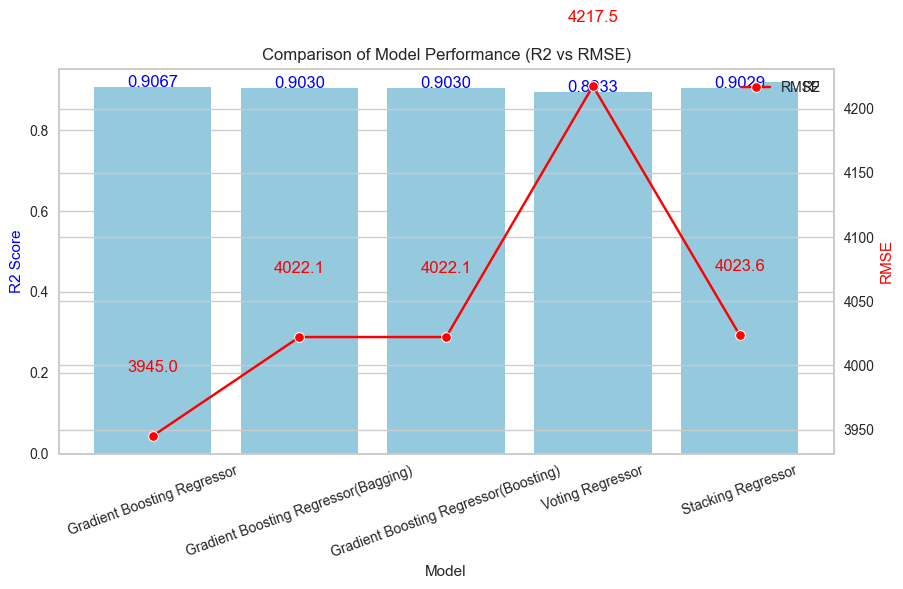

In [371]:
import seaborn as sns
import matplotlib.pyplot as plt  # Correct import
import pandas as pd

# Creating DataFrame from dictionary
Model_Evaluation = pd.DataFrame({
    'Model': ml_model_eval,
    'R2': ml_model_eval_R2,
    'RMSE': ml_model_eval_RMSE
})

# Set up the figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar plot for R2
sns.barplot(x="Model", y="R2", data=Model_Evaluation, ax=ax1, color="skyblue", label="R2")

# Annotate R2 values
for index, row in Model_Evaluation.iterrows():
    ax1.text(index, row["R2"] + 0.001, f"{row['R2']:.4f}", ha='center', color='blue')

# Line plot for RMSE (secondary axis)
ax2 = ax1.twinx()
sns.lineplot(x="Model", y="RMSE", data=Model_Evaluation, marker="o", color="red", ax=ax2, label="RMSE")

# Annotate RMSE values
for index, row in Model_Evaluation.iterrows():
    ax2.text(index, row["RMSE"] + 50, f"{row['RMSE']:.1f}", ha='center', color='red')

# Formatting
ax1.set_ylabel("R2 Score", color="blue")
ax2.set_ylabel("RMSE", color="red")
ax1.set_xlabel("Model")
ax1.set_title("Comparison of Model Performance (R2 vs RMSE)")
ax1.tick_params(axis="x", rotation=20)

# Show the plot
plt.show()





In [372]:
Model_Evaluation

,Model,R2,RMSE
0,Gradient Boosting Regressor,0.9067,3945.0074
1,Gradient Boosting Regressor(Bagging),0.9030,4022.1087
2,Gradient Boosting Regressor(Boosting),0.9030,4022.1087
3,Voting Regressor,0.8933,4217.5356
4,Stacking Regressor,0.9029,4023.6060


## Model Finalization

In [373]:
# Selecting the model with the highest R2
best_model_by_r2 = Model_Evaluation.loc[Model_Evaluation["R2"].idxmax()]

# Selecting the model with the lowest RMSE
best_model_by_rmse = Model_Evaluation.loc[Model_Evaluation["RMSE"].idxmin()]

# If both best R2 and best RMSE are from the same model, choose it. Otherwise, prioritize R2.
if best_model_by_r2["Model"] == best_model_by_rmse["Model"]:
    best_model_after_eval = best_model_by_r2.to_frame().T
else:
    best_model_after_eval = best_model_by_r2.to_frame().T  # Prioritize R2




In [374]:
#best_model_after_eval['Model']

In [375]:
import shutil
import os

In [376]:
best_model_after_eval.iloc[0,0]

'Gradient Boosting Regressor'

## Save Model

In [377]:
if best_model_after_eval.index[0] == 0:
    # Define the folder where the model should be saved
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_model_Regressor")
    save_model(best_model_final_fit,model_file_path)
    explain_model = tune_best_model_final
    explain_model_fit = best_model_final_fit
    
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(best_model_final_fit,plot = 'error' , save = True)
    plot_model(best_model_final_fit,plot = 'residuals' , save = True)
    #plot_model(best_model_final_fit,plot = 'feature' , save = True)
    shutil.move("Prediction Error.png", os.path.join(assets_folder, "error_plot.png"))
    shutil.move("Residuals.png", os.path.join(assets_folder, "residuals_plot.png"))
    #shutil.move("Feature Importance.png", os.path.join(assets_folder, "feature_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
elif best_model_after_eval.index[0] == 1:
    
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_model_Regressor_bagging")
    #save_model(best_model_final_fit,model_file_path)
    save_model(ensemble_bag_final_fit,model_file_path)
    explain_model = ensemble_bag
    explain_model_fit = ensemble_bag_final_fit
    
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(ensemble_bag_final_fit,plot = 'error' , save = True)
    plot_model(ensemble_bag_final_fit,plot = 'residuals' , save = True)
    #plot_model(ensemble_bag_final_fit,plot = 'feature' , save = True)
    shutil.move("Prediction Error.png", os.path.join(assets_folder, "error_plot.png"))
    shutil.move("Residuals.png", os.path.join(assets_folder, "residuals_plot.png"))
    #shutil.move("Feature Importance.png", os.path.join(assets_folder, "feature_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
elif best_model_after_eval.index[0] == 2:
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_Model_Regressor_Boosting")
    #save_model(best_model_final_fit,model_file_path)
    save_model(ensemble_boost_final_fit,model_file_path)
    explain_model = ensemble_boost
    explain_model_fit = ensemble_boost_final_fit
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(ensemble_boost_final_fit,plot = 'error' , save = True)
    plot_model(ensemble_boost_final_fit,plot = 'residuals' , save = True)
    #plot_model(ensemble_boost_final_fit,plot = 'feature' , save = True)
    shutil.move("Prediction Error.png", os.path.join(assets_folder, "error_plot.png"))
    shutil.move("Residuals.png", os.path.join(assets_folder, "residuals_plot.png"))
    #shutil.move("Feature Importance.png", os.path.join(assets_folder, "feature_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
elif best_model_after_eval.index[0] == 3:
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_Model_Regresor_Voting")
    
    save_model(voting_reg_final_fit,model_file_path)
    explain_model = voting_reg
    explain_model_fit = voting_reg_final_fit
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(voting_reg_final_fit,plot = 'error' , save = True)
    plot_model(voting_reg_final_fit,plot = 'residuals' , save = True)
    #plot_model(voting_reg_final_fit,plot = 'feature' , save = True)
    shutil.move("Prediction Error.png", os.path.join(assets_folder, "error_plot.png"))
    shutil.move("Residuals.png", os.path.join(assets_folder, "residuals_plot.png"))
    #shutil.move("Feature Importance.png", os.path.join(assets_folder, "feature_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    
else:
    
    model_folder = "models"
    os.makedirs(model_folder, exist_ok=True)  # Ensure the folder exists

    # Define the full file path
    model_file_path = os.path.join(model_folder, "Best_Model_Regressor_Stack")
    save_model(stack_reg_final_fit,model_file_path)
    explain_model = stack_reg
    explain_model_fit = stack_reg_final_fit
    assets_folder = "assets"
    os.makedirs(assets_folder, exist_ok=True)
    plot_model(stack_reg_final_fit,plot = 'error' , save = True)
    plot_model(stack_reg_final_fit,plot = 'residuals' , save = True)
    #plot_model(stack_reg_final_fit,plot = 'feature' , save = True)
    shutil.move("Prediction Error.png", os.path.join(assets_folder, "error_plot.png"))
    shutil.move("Residuals.png", os.path.join(assets_folder, "residuals_plot.png"))
    #shutil.move("Feature Importance.png", os.path.join(assets_folder, "feature_plot.png"))

    print("All plots successfully saved in the assets folder!")
    final_best_model = best_model_after_eval.iloc[0,0]
    

Transformation Pipeline and Model Successfully Saved


All plots successfully saved in the assets folder!


In [378]:
ml_model_report_inputs['final_best_model'] = final_best_model

In [379]:
assets_folder = "metadata"
os.makedirs(assets_folder, exist_ok=True)
json_file_path_ml_report = os.path.join(assets_folder, "ml_model_report_inputs.json")
with open(json_file_path_ml_report, 'w') as f:
    json.dump(ml_model_report_inputs, f,default=str)

## Explainable AI

## Global Explainability (Final)

In [380]:
import shap

In [381]:
# Ensure the assets folder exists
assets_folder = "assets"
os.makedirs(assets_folder, exist_ok=True)

sample = sample_reg

predict_fn = lambda x: explain_model.predict(x)

# Create a KernelExplainer on the transformed data
explainer = shap.KernelExplainer(predict_fn, sample)

# Compute SHAP values
shap_values = explainer.shap_values(sample)

# Plot the SHAP summary
shap.summary_plot(shap_values, sample,show = False)

shap_plot_path = os.path.join(assets_folder, "shap_summary_plot.png")
plt.savefig(shap_plot_path, bbox_inches="tight")

# Close the plot to free memory
plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

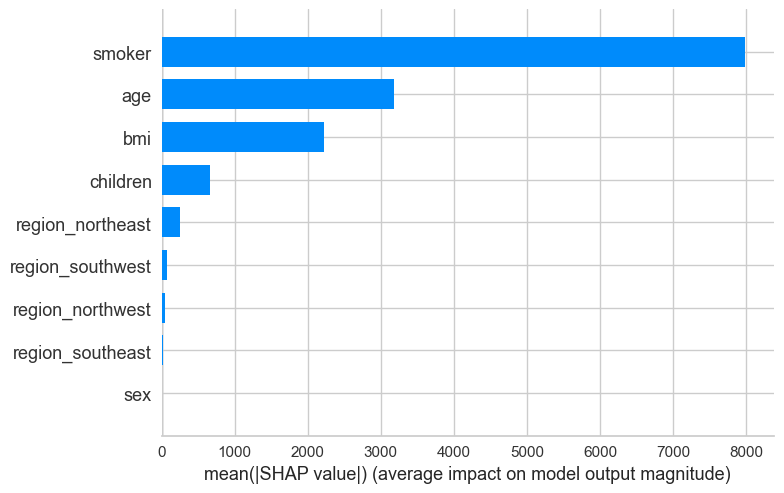

In [382]:
shap.summary_plot(shap_values,sample,plot_type='bar',show = False)
shap_plot_path = os.path.join(assets_folder, "shap_summary_plot_feature.png")
plt.savefig(shap_plot_path, bbox_inches="tight")

In [383]:
sample.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest',
       'region_southwest', 'region_northeast', 'region_southeast'],
      dtype='object')

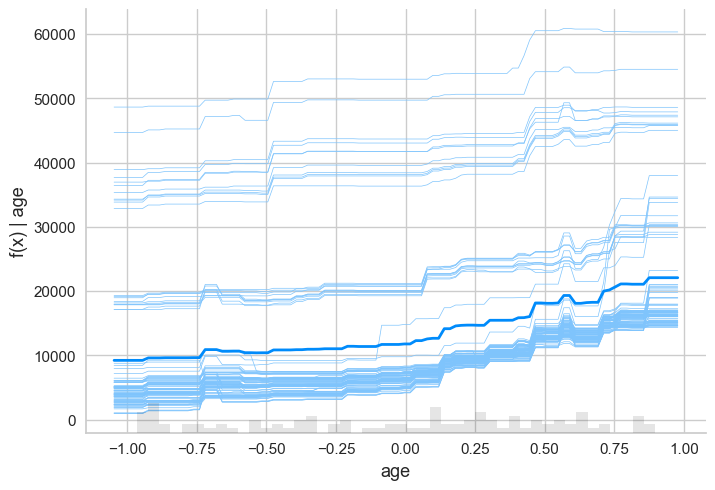

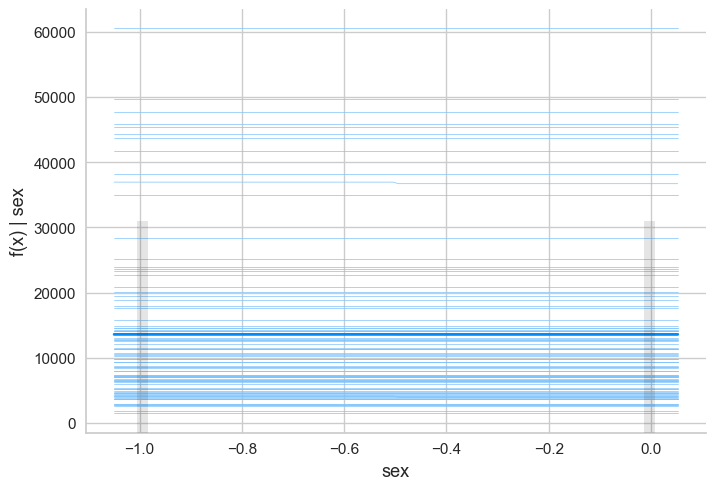

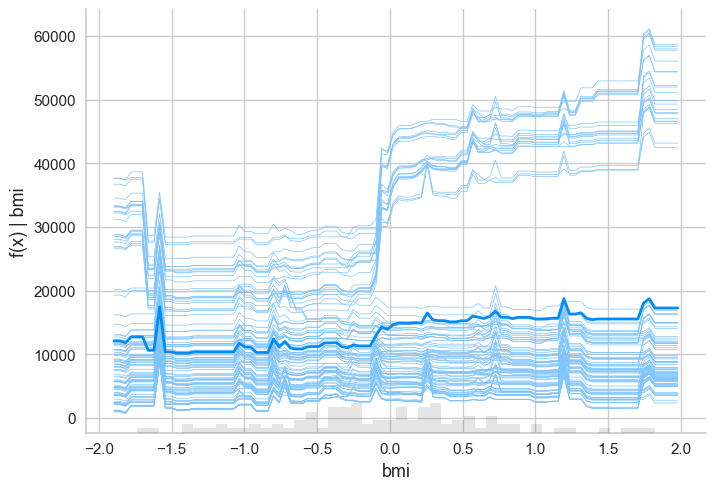

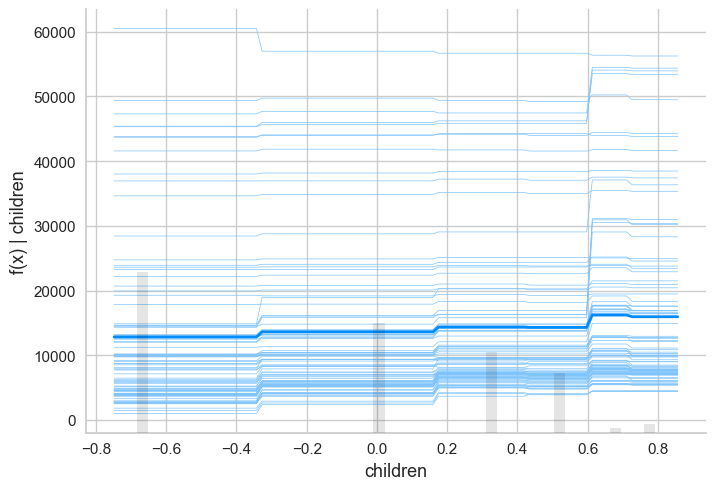

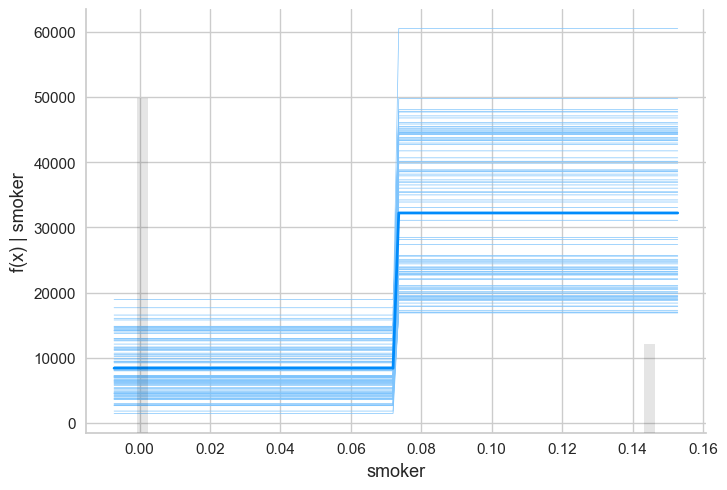

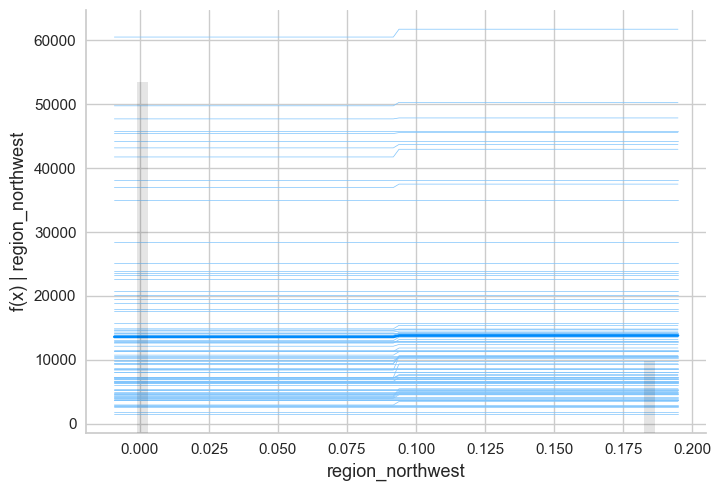

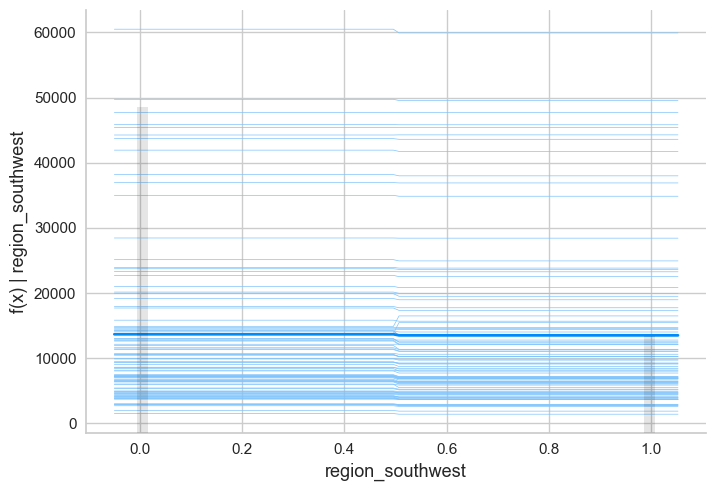

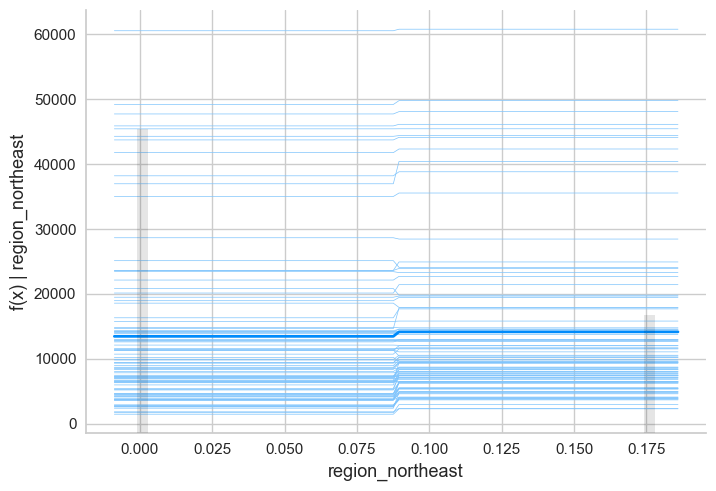

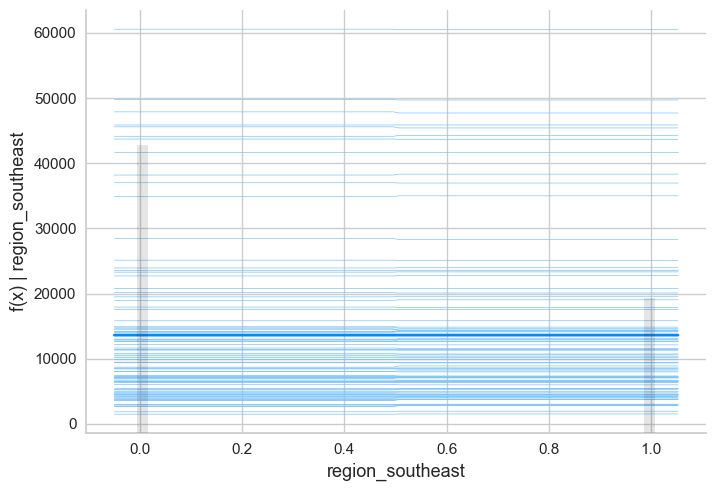

In [384]:
for feature in sample.columns:
    
    shap.partial_dependence_plot(feature,explain_model.predict,sample,show=False)
    name = f"shap_partial_{feature}.png"
    shap_plot_path = os.path.join(assets_folder, name)
    plt.savefig(shap_plot_path, bbox_inches="tight")
    

## Local Explainability (Final)

In [385]:
predict_fn = lambda x: explain_model.predict(x)

# Create a KernelExplainer on the transformed data
explainer = shap.KernelExplainer(predict_fn, sample)

for i in range(5):
    test_instance = sample.sample(n=1) 
    
    # Compute SHAP values for your test instance
    shap_values = explainer.shap_values(test_instance)

    # Extract the first explanation (since test_instance contains one sample, shap_values is shape (1, n_features))
    single_shap_values = shap_values[0]

    # Similarly, extract the corresponding data (the first row) from test_instance
    single_test_instance = test_instance.iloc[0]

    # Create an Explanation object using the single row
    exp_obj = shap.Explanation(
        values=single_shap_values,
        base_values=explainer.expected_value,  # if expected_value is a scalar, this is fine; if it's an array, you may need to index it too.
        data=single_test_instance,
        feature_names=sample.columns
    )

    # Now plot the waterfall plot for this single explanation
    fig, ax = plt.subplots(figsize=(8, 5))
    shap.waterfall_plot(exp_obj,show=False)
    name = f"shap_local_explain_sample_{i}.png"
    shap_plot_path = os.path.join(assets_folder, name)
    plt.savefig(shap_plot_path, bbox_inches="tight")
    plt.close(fig)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

pycaret interpret model only supports  lightgbm, dt, et, rf 

In [386]:
evaluate_model(best_model_final_fit)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### End of Code